In [1]:
#기본 IMPORT
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.manifold import TSNE


In [2]:
# 출력 줄수 제한 없애기

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity="all"



X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: t

<Figure size 1000x100 with 0 Axes>

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 6')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 7')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 3')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 1')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 0')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 6')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 5')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 9')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 4')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 8')

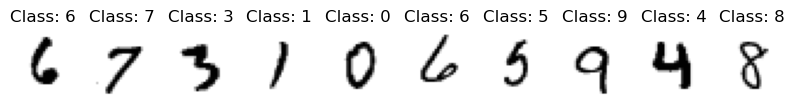

In [3]:
#Device 및 기본 설정 + 데이터셋 받아오기(MNIST)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE=32
EPOCHS=10

train_dataset = datasets.MNIST(root='data/MNIST',train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='data/MNIST',train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE, shuffle=False)

for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(),'type:',X_train.type())
    print('y_train:',y_train.size(), 'type:',y_train.type())

pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize)) #10개 plot하기 위한 figure 크기 설정

for i in range(10):
    plt.subplot(1, 10, i + 1) # plot.subplot(rows, columns, index)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [4]:
#모델을 4층구조 - Conv - Relu - Pooling 4층
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        
        self.fc3 = nn.Linear(256, 10)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool(F.gelu(self.bn2(self.conv2(x))))
        
        x = x.view(-1, 64 * 7 * 7)
        
        x = F.gelu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        
        x = F.gelu(self.bn_fc2(self.fc2(x)))
        x = self.dropout(x)
        
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x


In [5]:
#model,optimizer,criterion 설정
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.5)
criterion=nn.CrossEntropyLoss()

print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (bn_fc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn_fc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [6]:
# 학습 함수
def train(model, device, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")


In [15]:
# FGSM Attack Function
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

#FGSM(TSNE 시각화용)
def fgsm_attack_2(model, image, label, epsilon, criterion):
    # FGSM attack implementation
    image.requires_grad = True
    output = model(image)
    loss = criterion(output, label)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    perturbed_image = image + epsilon * data_grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image
# PGD Attack Function
def pgd_attack(model, image, label, epsilon, alpha, attack_iters, criterion):
    perturbed_image = image.clone().detach().requires_grad_(True).to(DEVICE)
    original_image = image.clone().detach()
    
    for _ in range(attack_iters):
        output = model(perturbed_image)
        loss = criterion(output, label)
        model.zero_grad()
        loss.backward()
        data_grad = perturbed_image.grad.data
        
        perturbed_image = perturbed_image + alpha * data_grad.sign()
        perturbation = torch.clamp(perturbed_image - original_image, min=-epsilon, max=epsilon)
        perturbed_image = torch.clamp(original_image + perturbation, 0, 1).detach_().requires_grad_(True)
    
    return perturbed_image

# Adversarial Training with FGSM
def train_with_fgsm(model, device, train_loader, optimizer, criterion, epochs, epsilon):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            data.requires_grad = True
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            data_grad = data.grad.data
            perturbed_data = fgsm_attack(data, epsilon, data_grad)
            
            output = model(perturbed_data)
            loss_adv = criterion(output, target)
            loss_adv.backward()
            optimizer.step()
            
            running_loss += loss.item() + loss_adv.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs} with FGSM Attack, Loss: {avg_loss:.4f}")

# Adversarial Training with PGD
def train_with_pgd(model, device, train_loader, optimizer, criterion, epochs, epsilon, alpha, attack_iters):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            perturbed_data = pgd_attack(model, data, target, epsilon, alpha, attack_iters, criterion)
            output = model(perturbed_data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs} with PGD Attack, Loss: {avg_loss:.4f}")




In [8]:
# Basic Evaluation Function
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(prediction.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    f1 = f1_score(all_labels, all_predictions, average='macro')
    cm = confusion_matrix(all_labels, all_predictions)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"F1 Score (Macro): {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)


In [9]:
def visualize_comparison(original_images_list, perturbed_images_list, original_labels_list, perturbed_preds_list, num_images=16):
    """
    Visualizes original and adversarial images side by side.
    
    Parameters:
    - original_images_list: List of tensors containing original images.
    - perturbed_images_list: List of tensors containing adversarial images.
    - original_labels_list: List of original labels.
    - perturbed_preds_list: List of adversarial predictions.
    - num_images: Number of image pairs to visualize.
    """
    # Concatenate all batches into a single tensor and ensure they are detached
    original_images = torch.cat(original_images_list, dim=0)[:num_images].detach()
    perturbed_images = torch.cat(perturbed_images_list, dim=0)[:num_images].detach()
    original_labels = np.concatenate(original_labels_list, axis=0)[:num_images]
    perturbed_preds = np.concatenate(perturbed_preds_list, axis=0)[:num_images]
    
    # Calculate the number of rows needed
    num_cols = 8  # Number of images per row
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate rows needed to display all images

    fig, axes = plt.subplots(2 * num_rows, num_cols, figsize=(2 * num_cols, 4 * num_rows))
    
    for i in range(num_images):
        row = (i // num_cols) * 2  # Determine the row index (original and adversarial)
        col = i % num_cols  # Determine the column index
        
        # Original Image
        axes[row, col].imshow(original_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[row, col].set_title(f"Original: {original_labels[i]}")
        axes[row, col].axis('off')
        
        # Adversarial Image
        axes[row + 1, col].imshow(perturbed_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[row + 1, col].set_title(f"Adversarial: {perturbed_preds[i]}")
        axes[row + 1, col].axis('off')
    
    # Hide any unused subplots
    for i in range(num_images, num_cols * num_rows):
        row = (i // num_cols) * 2
        col = i % num_cols
        axes[row, col].axis('off')
        axes[row + 1, col].axis('off')

    plt.tight_layout()
    plt.show()


In [36]:
def visualize_tsne(model, test_loader, epsilon, alpha, iterations, visualize=True, num_images=1000, mode='FGSM'):
    model.eval()
    images_list = []
    labels_list = []

    criterion = torch.nn.CrossEntropyLoss()

    for i, (images, labels) in enumerate(test_loader):
        if i * len(images) >= num_images:
            break

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Apply attack based on mode
        if mode == 'FGSM':
            perturbed_images = fgsm_attack_2(model, images, labels, epsilon, criterion)
        elif mode == 'PGD':
            perturbed_images = pgd_attack(model, images, labels, epsilon, alpha, iterations, criterion)
        else:
            raise ValueError("Mode must be either 'FGSM' or 'PGD'")

        # Collect original and perturbed images for TSNE
        with torch.no_grad():
            images_list.append(images)
            labels_list.append(labels)
            images_list.append(perturbed_images)
            labels_list.append(labels)

    # Stack all images and labels
    images_list = torch.cat(images_list, dim=0)
    labels_list = torch.cat(labels_list, dim=0).cpu().numpy()  # Move to CPU and convert to numpy

    # Pass images through the model to get the features
    with torch.no_grad():
        features = model(images_list).view(images_list.size(0), -1)

    # Apply TSNE to reduce to 2 dimensions
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features = tsne.fit_transform(features.cpu().numpy())

    # Plot the TSNE visualization
    if visualize:
        # Colors and markers for each class (0-9)
        colors = cm.get_cmap('tab10', 10)  # Using a colormap with 10 colors
        markers = ['o', 's', 'v', '^', '<', '>', 'P', '*', 'X', 'D']  # Different markers for diversity

        plt.figure(figsize=(12, 10))
        for class_idx in range(10):
            # Plot original images
            class_mask = (labels_list[:len(images_list)//2] == class_idx)
            plt.scatter(tsne_features[:len(images_list)//2, 0][class_mask], 
                        tsne_features[:len(images_list)//2, 1][class_mask], 
                        color=colors(class_idx), marker=markers[class_idx], label=f'Original {class_idx}', alpha=0.5)
            
            # Plot perturbed images
            class_mask = (labels_list[len(images_list)//2:] == class_idx)
            plt.scatter(tsne_features[len(images_list)//2:, 0][class_mask], 
                        tsne_features[len(images_list)//2:, 1][class_mask], 
                        color=colors(class_idx), marker=markers[class_idx], label=f'Perturbed {class_idx}', edgecolor='k', alpha=0.5)
        
        # Set the legend to appear in the top right and split into 2 columns
        plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=2)
        plt.title(f'TSNE Visualization - {mode} Attack')
        plt.show()

    return tsne_features, labels_list


In [11]:
# Evaluation with FGSM Attack
def evaluate_with_fgsm_attack(model, test_loader, criterion, epsilon, visualize=True, num_images=5):
    model.eval()
    clean_loss, adv_loss = 0, 0
    clean_correct, adv_correct = 0, 0
    clean_labels, clean_preds = [], []
    adv_labels, adv_preds = [], []
    
    # For Visualization
    original_images_list = []
    perturbed_images_list = []
    original_labels_list = []
    perturbed_preds_list = []
    
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        
        # Clean Evaluation
        output = model(data)
        clean_loss += criterion(output, target).item()
        clean_pred = output.max(1, keepdim=True)[1]
        clean_correct += clean_pred.eq(target.view_as(clean_pred)).sum().item()
        
        clean_labels.extend(target.cpu().numpy())
        clean_preds.extend(clean_pred.cpu().numpy())
        
        # FGSM Attack
        data.requires_grad = True
        output = model(data)
        loss = criterion(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        # Adversarial Evaluation
        output = model(perturbed_data)
        adv_loss += criterion(output, target).item()
        adv_pred = output.max(1, keepdim=True)[1]
        adv_correct += adv_pred.eq(target.view_as(adv_pred)).sum().item()
        
        adv_labels.extend(target.cpu().numpy())
        adv_preds.extend(adv_pred.cpu().numpy())
        
        # Save for Visualization
        if visualize and len(original_images_list) < num_images:
            # Detach tensors to prevent them from tracking gradients
            original_images_list.append(data.cpu().detach())
            perturbed_images_list.append(perturbed_data.cpu().detach())
            original_labels_list.append(target.cpu().numpy())
            perturbed_preds_list.append(adv_pred.cpu().numpy())
    
    # Calculate Metrics
    clean_loss /= len(test_loader)
    adv_loss /= len(test_loader)
    clean_accuracy = 100. * clean_correct / len(test_loader.dataset)
    adv_accuracy = 100. * adv_correct / len(test_loader.dataset)
    
    clean_f1 = f1_score(clean_labels, clean_preds, average='macro')
    adv_f1 = f1_score(adv_labels, adv_preds, average='macro')
    
    clean_cm = confusion_matrix(clean_labels, clean_preds)
    adv_cm = confusion_matrix(adv_labels, adv_preds)
    
    print(f"Adversarial Test Loss: {adv_loss:.4f}, Adversarial Accuracy: {adv_accuracy:.2f}%")
    print(f"Adversarial F1 Score (Macro): {adv_f1:.4f}")
    print("Adversarial Confusion Matrix:")
    print(adv_cm)
    print(len(original_images_list))
    return original_images_list,perturbed_images_list,original_labels_list,perturbed_preds_list
    # Visualization
    if visualize and original_images_list and perturbed_images_list:
        visualize_comparison(original_images_list, perturbed_images_list, original_labels_list, perturbed_preds_list, num_images=num_images)

# Evaluation with PGD Attack
def evaluate_with_pgd_attack(model, test_loader, criterion, epsilon, alpha, attack_iters, visualize=True, num_images=5):
    model.eval()
    clean_loss, adv_loss = 0, 0
    clean_correct, adv_correct = 0, 0
    clean_labels, clean_preds = [], []
    adv_labels, adv_preds = [], []
    
    # For Visualization
    original_images_list = []
    perturbed_images_list = []
    original_labels_list = []
    perturbed_preds_list = []
    
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        
        # Clean Evaluation
        output = model(data)
        clean_loss += criterion(output, target).item()
        clean_pred = output.max(1, keepdim=True)[1]
        clean_correct += clean_pred.eq(target.view_as(clean_pred)).sum().item()
        
        clean_labels.extend(target.cpu().numpy())
        clean_preds.extend(clean_pred.cpu().numpy())
        
        # PGD Attack
        perturbed_data = pgd_attack(model, data, target, epsilon, alpha, attack_iters, criterion)
        
        # Adversarial Evaluation
        output = model(perturbed_data)
        adv_loss += criterion(output, target).item()
        adv_pred = output.max(1, keepdim=True)[1]
        adv_correct += adv_pred.eq(target.view_as(adv_pred)).sum().item()
        
        adv_labels.extend(target.cpu().numpy())
        adv_preds.extend(adv_pred.cpu().numpy())
        
        # Save for Visualization
        if visualize and len(original_images_list) < num_images:
            original_images_list.append(data.cpu())
            perturbed_images_list.append(perturbed_data.cpu())
            original_labels_list.append(target.cpu().numpy())
            perturbed_preds_list.append(adv_pred.cpu().numpy())
    
    # Calculate Metrics
    clean_loss /= len(test_loader)
    adv_loss /= len(test_loader)
    clean_accuracy = 100. * clean_correct / len(test_loader.dataset)
    adv_accuracy = 100. * adv_correct / len(test_loader.dataset)
    
    clean_f1 = f1_score(clean_labels, clean_preds, average='macro')
    adv_f1 = f1_score(adv_labels, adv_preds, average='macro')
    
    clean_cm = confusion_matrix(clean_labels, clean_preds)
    adv_cm = confusion_matrix(adv_labels, adv_preds)
    
    # Print Results
    print(f"Adversarial Test Loss (PGD): {adv_loss:.4f}, Adversarial Accuracy (PGD): {adv_accuracy:.2f}%")
    print(f"Adversarial F1 Score (Macro, PGD): {adv_f1:.4f}")
    print("Adversarial Confusion Matrix (PGD):")
    print(adv_cm)
    return original_images_list, perturbed_images_list, original_labels_list,perturbed_preds_list
    # Visualization
    if visualize and original_images_list and perturbed_images_list:
        visualize_comparison(original_images_list, perturbed_images_list, original_labels_list, perturbed_preds_list, num_images=num_images)


In [12]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (bn_fc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn_fc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [16]:
#훈련시의 파라미터
epsilon=0.2
alpha=0.1
iterations=20

### Basic Training Execution
### Uncomment to perform basic training without adversarial attacks
train(model, DEVICE, train_loader, optimizer, criterion, EPOCHS)

# Adversarial Training Execution

### FGSM Adversarial Training
### Uncomment the following line to perform FGSM adversarial training
# train_with_fgsm(model, DEVICE, train_loader, optimizer, criterion, EPOCHS, epsilon)

### PGD Adversarial Training
### print("Starting PGD Adversarial Training...")
# train_with_pgd(model, DEVICE, train_loader, optimizer, criterion, EPOCHS, epsilon, alpha, iterations)


Epoch 1/10 with FGSM Attack, Loss: 0.7875
Epoch 2/10 with FGSM Attack, Loss: 0.4690
Epoch 3/10 with FGSM Attack, Loss: 0.3884
Epoch 4/10 with FGSM Attack, Loss: 0.3365
Epoch 5/10 with FGSM Attack, Loss: 0.3005
Epoch 6/10 with FGSM Attack, Loss: 0.2696
Epoch 7/10 with FGSM Attack, Loss: 0.2489
Epoch 8/10 with FGSM Attack, Loss: 0.2361
Epoch 9/10 with FGSM Attack, Loss: 0.2184
Epoch 10/10 with FGSM Attack, Loss: 0.2007


In [24]:
# Evaluation 함수들 모으 

#공격시의 파라미터 설정
epsilon=0.1
alpha=0.1
iterations=30
# Evaluate on clean test data
print("\n--- Evaluating on Clean Test Data ---")
evaluate(model, test_loader, criterion)

# Evaluate with FGSM Attack
print("\n--- Evaluating with FGSM Attack ---")
fgsm_original_images,fgsm_perturbed_images,fgsm_origial_labels,fgsm_perturbed_labels=evaluate_with_fgsm_attack(model, test_loader, criterion, epsilon, visualize=True, num_images=5)

# Evaluate with PGD Attack
print("\n--- Evaluating with PGD Attack ---")
pgd_original_images,pgd_perturbed_images,pgd_origial_labels,pgd_perturbed_labels=evaluate_with_pgd_attack(model, test_loader, criterion, epsilon, alpha, iterations, visualize=True, num_images=5)


--- Evaluating on Clean Test Data ---
Test Loss: 0.0296
Test Accuracy: 99.12%
F1 Score (Macro): 0.9912
Confusion Matrix:
[[ 975    1    0    0    0    0    3    1    0    0]
 [   0 1133    2    0    0    0    0    0    0    0]
 [   1    0 1025    0    1    0    0    5    0    0]
 [   0    0    1 1003    0    2    0    2    2    0]
 [   0    0    0    0  979    0    3    0    0    0]
 [   2    0    0    3    0  885    1    1    0    0]
 [   3    3    0    0    1    1  949    0    1    0]
 [   0    6    4    0    0    0    0 1018    0    0]
 [   3    0    2    1    0    1    0    3  961    3]
 [   0    4    0    1   12    1    0    7    0  984]]

--- Evaluating with FGSM Attack ---
Adversarial Test Loss: 0.3949, Adversarial Accuracy: 87.47%
Adversarial F1 Score (Macro): 0.8807
Adversarial Confusion Matrix:
[[965   0   2   0   0   0   6   2   5   0]
 [  4 884   7   1   0   2   8   0 229   0]
 [ 14   0 950   3   2   0   6   8  49   0]
 [  5   0  11 839   0  19   0   7 117  12]
 [  6   0  

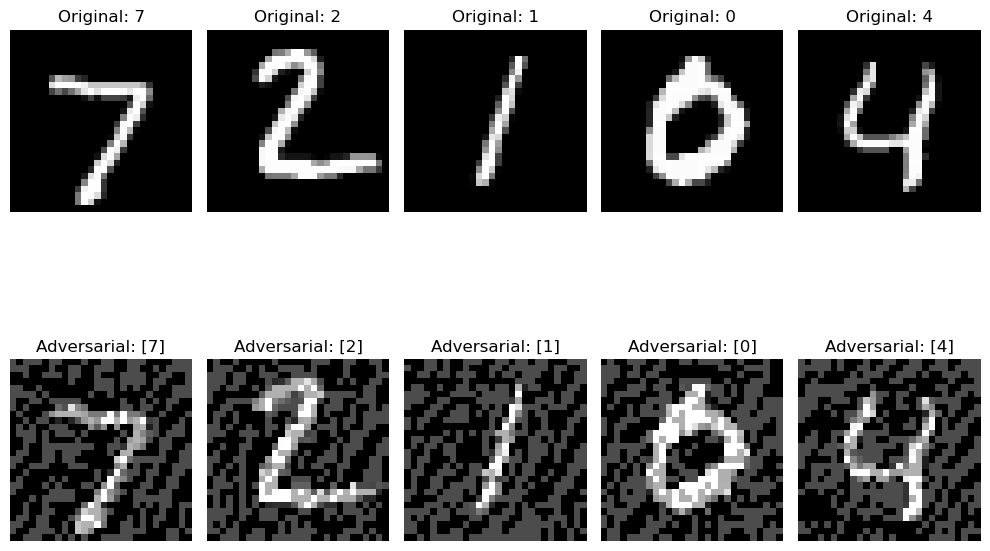

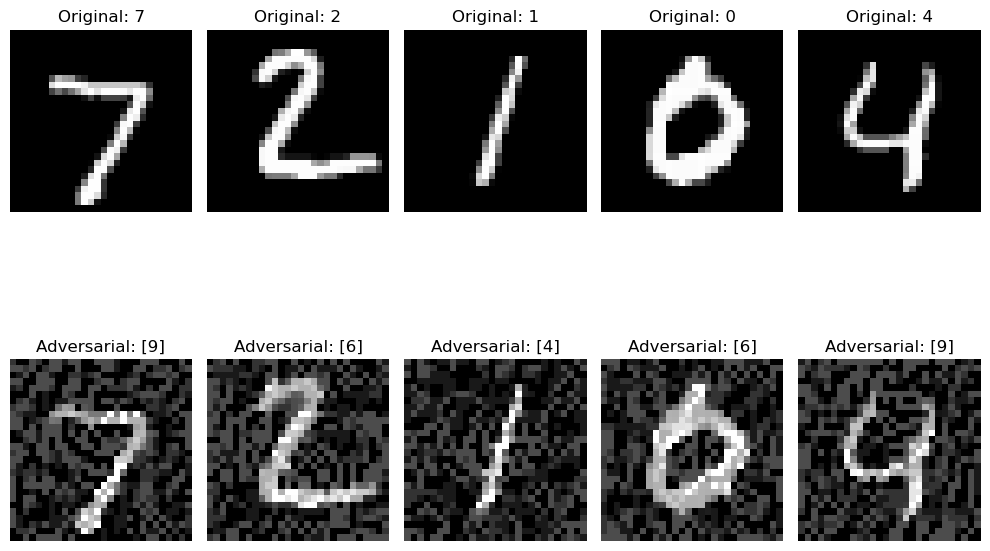

In [30]:
## Visualize 함수


visualize_comparison(fgsm_original_images,fgsm_perturbed_images,fgsm_origial_labels,fgsm_perturbed_labels, num_images=5)

visualize_comparison(pgd_original_images,pgd_perturbed_images,pgd_origial_labels,pgd_perturbed_labels, num_images=5)

C:\Users\user\AppData\Local\Temp\ipykernel_16200\688231516.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', 10)  # Using a colormap with 10 colors


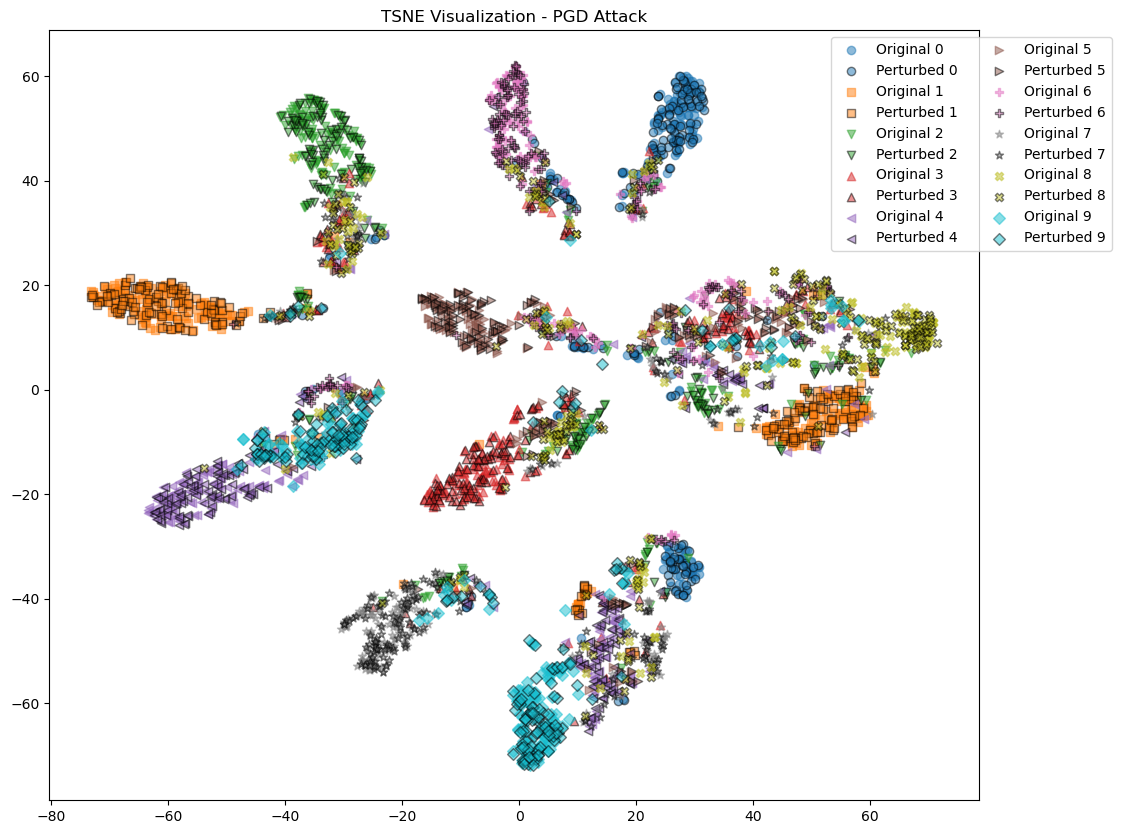

In [40]:
# FGSM 기반 시각화
tsne_features, labels = visualize_tsne(
    model=model, 
    test_loader=test_loader, 
    epsilon=epsilon, 
    alpha=alpha, 
    iterations=iterations, 
    visualize=True, 
    num_images=2000, 
    mode='PGD'
)